### Label alignment in RGDR
This notebook outlines how labelled precursor regions found with RGDR can be aligned over training splits.

### Load packages and data

First we will load in some example data, and resample them using the `AdventCalendar`

In [49]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR
from s2spy.rgdr import utils

import matplotlib as mpl
import pandas as pd


file_path = '../s2spy/tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

cal = s2spy.time.AdventCalendar((8, 31), freq = "30d")
cal = cal.map_to_data(field)
field_resampled = s2spy.time.resample(cal, field)
target_resampled = s2spy.time.resample(cal, target)

### Train test splitting
Apply traintest splitting. To get some interesting results, let's do 4 splits.

In [50]:
# Cross-validation
from random import shuffle
from sklearn.model_selection import KFold, ShuffleSplit
import s2spy.traintest

seed = 1 #same 'randomness'
n_splits = 4

desired_cv = 'shufflesplit'

if desired_cv == 'shufflesplit':
    shufflesplit = ShuffleSplit(n_splits=n_splits, test_size=0.25, random_state = seed)
    cv = s2spy.traintest.TrainTestSplit(shufflesplit)
    for x_train, x_test, y_train, y_test in cv.split(field_resampled, y=target_resampled):
        print("Train:", x_train.anchor_year.values)
        print("Test:", x_test.anchor_year.values)
elif desired_cv == 'kfold':
    kfold = KFold(n_splits=n_splits)
    cv = s2spy.traintest.TrainTestSplit(kfold)
    for x_train, x_test, y_train, y_test in cv.split(field_resampled, y=target_resampled):
        print("Train:", x_train.anchor_year.values)
        print("Test:", x_test.anchor_year.values)
else:
    print('Desired cv method is unknown.')

Train: [2011 1997 2009 2015 2012 2007 1984 1994 1990 2014 2003 2004 2013 2000
 1998 1986 1993 1987 2018 1981 1996 1980 1995 1985 1991 1989 1988 1992
 2017]
Test: [1982 2010 1983 2001 2006 2008 2002 2016 1999 2005]
Train: [1990 2002 2013 1982 1998 2006 1980 1995 1989 2016 1996 2000 1992 1991
 2009 2017 1984 2012 2005 1997 2001 1986 1983 1987 2010 2018 1993 2004
 1988]
Test: [2014 1999 2003 1985 2008 2007 1981 2011 2015 1994]
Train: [2009 1991 1982 1996 1985 1984 1986 2000 2004 1983 1993 1997 1981 2010
 1980 1994 2015 2018 1987 2005 2013 2016 1995 2003 1990 2014 2012 1988
 1999]
Test: [2006 2002 1998 1992 2001 1989 2011 2007 2017 2008]
Train: [2007 1986 2006 2010 2009 1996 2015 1982 2002 1999 2016 1989 1981 1992
 1980 2000 2013 2004 2005 2018 1997 2008 2003 1990 1993 2012 1998 1984
 1987]
Test: [2017 1983 2011 1985 1995 1988 1994 1991 2014 2001]


### Take target timeseries from some cluster for both splits

In [51]:
#select target timeseries over training splits, select cluster 3
#select precursor fields over training splits, lags 1 up to 5
target_timeseries_splits = []
precursor_field_splits = []
for x_train, x_test, y_train, y_test in cv.split(field_resampled, y=target_resampled):
    target_timeseries_splits.append(target_resampled.sel(anchor_year=x_train.anchor_year.values, cluster=3).ts.isel(i_interval=0))
    precursor_field_splits.append(field_resampled.sel(anchor_year=x_train.anchor_year.values).sst.isel(i_interval=slice(1,5)))

initialize RGDR

In [52]:
rgdr = RGDR(eps_km=1000, alpha=0.05, min_area_km2=3000**2)

### Plot Correlation
Using `.plot_correlation` we can see the correlation and p-value map of the target timeseries and precursor field:

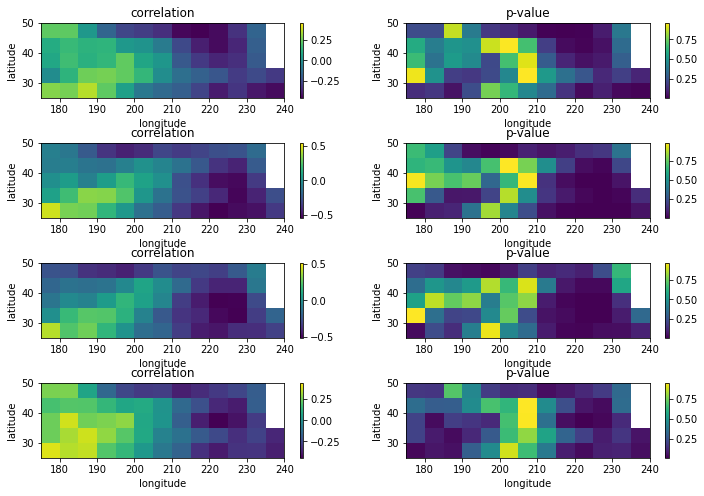

In [53]:
fig, axs = plt.subplots(ncols=2, nrows=n_splits, figsize=(12, 2*n_splits), gridspec_kw={'hspace':0.6})
for split_i, split in enumerate(precursor_field_splits):
    _ = rgdr.preview_correlation(precursor_field_splits[split_i], target_timeseries_splits[split_i], lag=1, ax1=axs[split_i,0], ax2=axs[split_i,1])

### Clustering

Cluster using RGDR and save the cluster arrays for every split

In [54]:
for split_i, split in enumerate(precursor_field_splits):
    # do rgdr clustering for every split
    clusters = rgdr.get_clusters(precursor_field_splits[split_i], target_timeseries_splits[split_i])
    clusters = utils.cluster_labels_to_ints(clusters)
    #create new array of only the cluster labels with dimension split
    if split_i == 0:
        cluster_labels = clusters.cluster_labels.expand_dims({'split':1})
    else:
        cluster_labels = xr.concat([cluster_labels,clusters.cluster_labels],'split')

### Plot Clusters

We can compare the difference between the clusters over the splits.

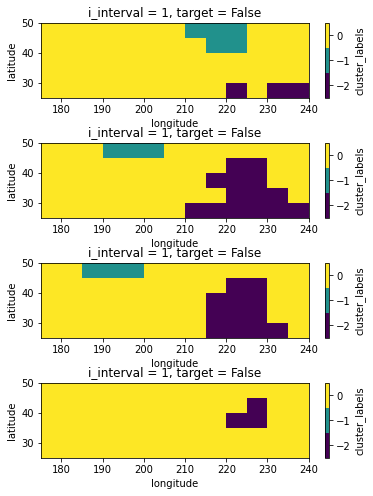

In [55]:
#first determine vmin and vmax for lag = 1
min_label_value = np.min(cluster_labels.sel({'i_interval': 1}).cluster_labels.values)
max_label_value = np.max(cluster_labels.sel({'i_interval': 1}).cluster_labels.values)

#plot using vmin and vmax to get the same colours for the same label ints over all plots
fig, axs = plt.subplots(ncols=1, nrows=len(cluster_labels.split), figsize=(6, 2*len(cluster_labels.split)), gridspec_kw={'hspace':0.6})
for split_i, split in enumerate(precursor_field_splits):
    _ = rgdr.preview_clusters(precursor_field_splits[split_i], target_timeseries_splits[split_i], 
    lag=1, ax=axs[split_i], cmap='viridis', vmin=min_label_value, vmax=max_label_value)

### A dataframe that shows overlap of clusters
See how regions found in one split overlap with regions with the same correlation sign in other splits, for the same lag.

In [122]:
from s2spy.rgdr import label_alignment

overlap_df = label_alignment.overlap_labels(cluster_labels, lag=1)
overlap_df = overlap_df.drop(columns='label_cell_count')
overlap_df

split               0                   1                   2            \
label              -2        -1        -2        -1        -2        -1   
split label                                                               
0     -2          NaN       NaN  1.000000  0.000000  0.666667  0.000000   
      -1          NaN       NaN  0.200000  0.000000  0.200000  0.000000   
1     -2     0.214286  0.071429       NaN       NaN  0.785714  0.000000   
      -1     0.000000  0.000000       NaN       NaN  0.000000  0.666667   
2     -2     0.166667  0.083333  0.916667  0.000000       NaN       NaN   
      -1     0.000000  0.000000  0.000000  0.666667       NaN       NaN   
3     -2     0.000000  0.000000  1.000000  0.000000  1.000000  0.000000   

split               3  
label              -2  
split label            
0     -2     0.000000  
      -1     0.000000  
1     -2     0.214286  
      -1     0.000000  
2     -2     0.250000  
      -1     0.000000  
3     -2          NaN

In [150]:
from typing import List, Set
import string

def get_overlapping_clusters(cluster_labels, lag: int, min_overlap: float = 0.1):
    overlap_df = label_alignment.overlap_labels(cluster_labels, lag=1)
    overlap_df = overlap_df.drop(columns='label_cell_count')
    overlap_df.columns = [
        '_'.join([str(el) for el in col]) for col in overlap_df.columns.values
        ]  # type: ignore
    overlap_df.index = [
        '_'.join([str(el) for el in idx]) for idx in overlap_df.index.values
        ]  # type: ignore

    clusters = set()
    for row in range(overlap_df.index.size): # type: ignore
        overlapping = overlap_df.iloc[row].where(overlap_df.iloc[row] > min_overlap).dropna()
        cluster = set(overlapping.index)
        cluster.add(overlap_df.iloc[row].name)
        clusters.add(frozenset(cluster))

    return clusters

def remove_subsets(clusters: Set):
    no_subsets = set(clusters)
    for cluster in clusters:
        no_subsets.remove(cluster)
        if not any(cluster.issubset(cl) for cl in no_subsets):
            no_subsets.add(cluster)
    return no_subsets

def remove_overlapping_clusters(clusters: Set):
    clusterlist = [set(cl) for cl in clusters]
    clusterlist.sort(key=len)
    sanitised_clusters = []
    for _ in range(len(clusterlist)):
        cluster = clusterlist.pop(0)
        [cluster.difference_update(cl) for cl in clusterlist]
        sanitised_clusters.append(cluster)
    return {frozenset(cluster) for cluster in sanitised_clusters}

def name_clusters(clusters: Set):
    #Ensure a sufficiently long list of possible names
    cluster_names = list(string.ascii_uppercase) + list(string.ascii_lowercase) 

    named_clusters = {}
    for cluster in clusters:
        name = cluster_names.pop(0)
        named_clusters[name] = set(cluster)
        
    return named_clusters

In [155]:
clusters = get_overlapping_clusters(cluster_labels, lag=1, min_overlap=0.01)
print(clusters, '\n')
clusters = remove_subsets(clusters)
print(clusters, '\n')
clusters = remove_overlapping_clusters(clusters)
print(clusters, '\n')
name_clusters(clusters)



{frozenset({'0_-1', '2_-2', '1_-2'}), frozenset({'2_-1', '1_-1'}), frozenset({'3_-2', '2_-2', '0_-1', '0_-2', '1_-2'}), frozenset({'3_-2', '2_-2', '1_-2'}), frozenset({'0_-2', '2_-2', '1_-2'})} 

{frozenset({'2_-1', '1_-1'}), frozenset({'3_-2', '2_-2', '0_-1', '0_-2', '1_-2'})} 

{frozenset({'3_-2', '2_-2', '0_-1', '0_-2', '1_-2'}), frozenset({'2_-1', '1_-1'})} 



{'A': {'0_-1', '0_-2', '1_-2', '2_-2', '3_-2'}, 'B': {'1_-1', '2_-1'}}

In [157]:
cluster_labels.sel(i_interval=1)

<xarray.DataArray 'cluster_labels' (split: 4, latitude: 5, longitude: 13)>
array([[[ 0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0, -2, -2]],

       [[ 0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -2, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -2, -2, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -2, -2, -2,  0],
        [ 0,  0,  0,  0,  0,  0,  0, -2, -2, -2, -2, -2, -2]],

       [[ 0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -2, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -2, -2, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -2, -2, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -2, -2, -2, -2,  0]],

       [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -2, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]])
Coordinates:
  * latitude        (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * longitude       (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
    i_interval      int64 1
    target          bool False
    area            (latitude, longitude) float64 3.34e+06 ... 4.385e+06
    cluster_labels  (split, latitude, longitude) int32 0 0 0 0 0 0 ... 0 0 0 0 0
Dimensions without coordinates: split

In [95]:
from typing import Dict
import uuid

overlap_df = label_alignment.overlap_labels(cluster_labels, lag=1)
overlap_df = overlap_df.drop(columns='label_cell_count')
overlap_df.columns = ['_'.join([str(el) for el in col]) for col in overlap_df.columns.values]  # type: ignore
overlap_df.index = ['_'.join([str(el) for el in idx]) for idx in overlap_df.index.values]  # type: ignore

# import string
# string.ascii_uppercase
# cluster_names = list(string.ascii_uppercase) + list(string.ascii_lowercase)

sets = {}
for row in range(overlap_df.index.size): # type: ignore
    overlapping = overlap_df.iloc[row].where(overlap_df.iloc[row] > 0.01).dropna()
    name = uuid.uuid4() # cluster_names.pop(0)
    sets[name] = set(overlapping.index)
    sets[name].add(overlap_df.iloc[row].name)

clusters = {frozenset(cluster_set) for cluster_set in sets.values()}

unique_labels = [list(sets.keys())[list(sets.values()).index(cluster)]
                 for cluster
                 in clusters]
unique_clusters = {key: sets[key] for key in unique_labels}
unique_clusters

{UUID('0acc52c6-641a-4a3c-97b5-786bda64207b'): {'0_-1', '1_-2', '2_-2'},
 UUID('2935e9b9-d032-4dea-89b5-3f3763ee0ea8'): {'1_-1', '2_-1'},
 UUID('9c6f0246-1de1-4afb-b5f3-e7769d496623'): {'0_-1',
  '0_-2',
  '1_-2',
  '2_-2',
  '3_-2'},
 UUID('57e89c42-5b1e-4d66-957d-b5b5767c8b87'): {'1_-2', '2_-2', '3_-2'},
 UUID('e3f7fdab-90e8-46dd-88d5-cf8082fdc191'): {'0_-2', '1_-2', '2_-2'}}

In [96]:
unique_clusters.values()

dict_values([{'0_-1', '2_-2', '1_-2'}, {'2_-1', '1_-1'}, {'3_-2', '0_-2', '1_-2', '2_-2', '0_-1'}, {'3_-2', '2_-2', '1_-2'}, {'0_-2', '2_-2', '1_-2'}])

In [97]:
cpy_unique_clusters = dict(unique_clusters)
subsets_removed = {}
for key in unique_clusters:
    val = cpy_unique_clusters.pop(key)
    if not any(val.issubset(cluster) for cluster in cpy_unique_clusters.values()):
        subsets_removed[key] = val
subsets_removed

{UUID('2935e9b9-d032-4dea-89b5-3f3763ee0ea8'): {'1_-1', '2_-1'},
 UUID('9c6f0246-1de1-4afb-b5f3-e7769d496623'): {'0_-1',
  '0_-2',
  '1_-2',
  '2_-2',
  '3_-2'},
 UUID('57e89c42-5b1e-4d66-957d-b5b5767c8b87'): {'1_-2', '2_-2', '3_-2'},
 UUID('e3f7fdab-90e8-46dd-88d5-cf8082fdc191'): {'0_-2', '1_-2', '2_-2'}}

In [99]:
import string
# Ensure a sufficiently long list of possible names
cluster_names = list(string.ascii_uppercase) + list(string.ascii_lowercase) 

for key in dict(subsets_removed):
    name = cluster_names.pop(0)
    subsets_removed[name] = subsets_removed.pop(key)

In [100]:
subsets_removed

{'A': {'1_-2', '2_-2', '3_-2'},
 'B': {'0_-2', '1_-2', '2_-2'},
 'C': {'1_-1', '2_-1'},
 'D': {'0_-1', '0_-2', '1_-2', '2_-2', '3_-2'}}

In [102]:
type(subsets_removed["A"])

set

In [58]:
from s2spy.rgdr import label_alignment

overlap_df = label_alignment.overlap_labels(cluster_labels, lag=1)
overlap_df = overlap_df.drop(columns='label_cell_count')
overlap_df.columns = ['_'.join([str(el) for el in col]) for col in overlap_df.columns.values]
overlap_df.index = ['_'.join([str(el) for el in idx]) for idx in overlap_df.index.values]



import string
cluster_names = list(string.ascii_uppercase)
for split in splits:
    for cluster in split:
        if cluster.name[0] not in string.ascii_uppercase:  # Check if already renamed
            name = cluster_names.pop(0)
            #rename this cluster A
            #find this cluster in other splits, also rename
            #

# End up with only named clusters.

######## Robustness Report ######
# Clusters found:
#   A in 3/4 splits, with average X% overlap.
#   B in 4/4 splits, with average X% overlap.
#
#######


NameError: name 'splits' is not defined

In [ ]:
# Create mapping


InvalidIndexError: (slice(None, None, None), slice(0, 6, None))

pretty print a little bit:

In [ ]:
format_mapping = {}
for col in overlap_df:
    format_mapping[col] = "{:.2f}"
format_mapping[('label_cell_count','')] = "{:,.0f}"
overlap_df.style.format(format_mapping)

### Align regions

Cluster labelled -1 in split 0 has zero overlap with the clusters labelled -1 in the other splits, but it does have overlap with a cluster labelled -2 in split 1 and split 2, so it gets the label -2.
In the current implementation a cluster with label y takes over the label x if the mean overlap with clusters labelled x in other splits is bigger than the overlap with clusters labelled y in other splits.

In [ ]:
cluster_labels_aligned = label_alignment.align_labels(cluster_labels, lag=1)

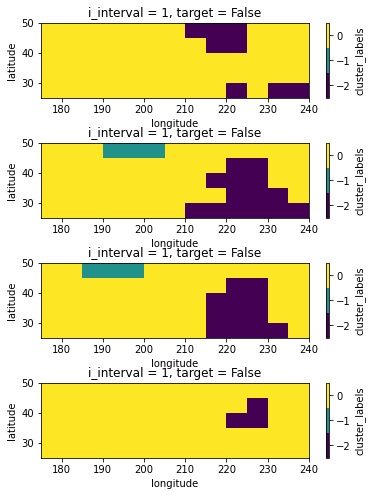

In [ ]:
#select lag 1 on cluster_labels_aligned
cluster_labels_aligned_lag1 = cluster_labels_aligned.sel({'i_interval':1})

# some things for nice plotting
vmin = np.min(cluster_labels_aligned_lag1.cluster_labels.values)
vmax = np.max(cluster_labels_aligned_lag1.cluster_labels.values)
N = vmax - vmin + 1
cmap = plt.cm.get_cmap('viridis', N)
cbar_kwargs = {'ticks': np.linspace(vmin,vmax,N)}

#plot
fig, axs = plt.subplots(ncols=1, nrows=len(cluster_labels_aligned_lag1.split), figsize=(6, 2*len(cluster_labels_aligned_lag1.split)), gridspec_kw={'hspace':0.6})
for split_i, split in enumerate(cluster_labels_aligned_lag1):
    split.plot(cmap=cmap, ax=axs[split_i], vmin=vmin-0.5, vmax=vmax+0.5, cbar_kwargs=cbar_kwargs)

In [ ]:
overlap_df_aligned = label_alignment.overlap_labels(cluster_labels_aligned, lag=1)
overlap_df_aligned

split               0         1                   2                   3  \
label              -2        -2        -1        -2        -1        -2   
split label                                                               
0     -2          NaN  0.500000  0.000000  0.375000  0.000000  0.000000   
1     -2     0.285714       NaN       NaN  0.785714  0.000000  0.214286   
      -1     0.000000       NaN       NaN  0.000000  0.666667  0.000000   
2     -2     0.250000  0.916667  0.000000       NaN       NaN  0.250000   
      -1     0.000000  0.000000  0.666667       NaN       NaN  0.000000   
3     -2     0.000000  1.000000  0.000000  1.000000  0.000000       NaN   

split       label_cell_count  
label                         
split label                   
0     -2                   8  
1     -2                  14  
      -1                   3  
2     -2                  12  
      -1                   3  
3     -2                   3


To add:
- Only compare to regions with the same correlation sign (although it is not very likely that you find clusters in the same area with opposing signs over splits, it is good for safety)
- Threshold for the overlap (only if the overlap is e.g. > 30%, it takes over the label)
- Threshold for the number of splits it should at least overlap with

Depending on RGDR outcome and alignment algorithm:
- User feedback on:
    - Regions differ too much over splits, consider increasing RGDR eps_km
    - Give the user an option to indicate which cluster should get another label (expert insight)